# Arquitectura Transformer
Este notebook está diseñado para acompañar la sección **Arquitectura Transformer** de las diapositivas.

Incluye:
- Repaso rápido de PLN (tareas típicas)
- Atención (Q,K,V) con intuición + matemática
- Self-attention, máscara causal, multi-head attention
- Residual + LayerNorm (Pre-Norm) + FFN
- Encoder, Decoder, y Transformer Encoder–Decoder **desde cero** (mini-implementación sencilla)
- Ejercicios (TODO) intercalados


In [ ]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 42
set_seed(seed)
print('Seed set with value ', seed)

Seed set with value  42


## 1) Mini repaso PLN (muy breve)
Tareas comunes:
- Tokenización / subwords
- POS / NER
- Clasificación (sentimiento, spam)
- Traducción / resumen
- QA

Problema central: **texto → números** (IDs → embeddings).

## 2) Atención: intuición y fórmula
### Intuición (Q, K, V)
- **Query (Q)**: lo que *busco*.
- **Key (K)**: cómo describo cada elemento *disponible*.
- **Value (V)**: la información que *me llevo* si atiendo a ese elemento.

La atención hace:
1) calcula similitud entre Q y K (scores)
2) normaliza con softmax → pesos
3) combina V con esos pesos → salida

### Fórmula
$$\mathrm{Att}(Q,K,V)=\mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V$$


### Implementación base: scaled dot-product attention

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None, dropout_p=0.0):
    """
    Scaled dot-product attention (núcleo del Transformer).

    Q: (B, h, Tq, d)  queries
    K: (B, h, Tk, d)  keys
    V: (B, h, Tk, d)  values
    mask: (1 o B, 1 o h, Tq, Tk)
          0    -> permitido
          -inf -> bloqueado
    """
    # Dimensión por head
    d = Q.size(-1)

    # Producto punto QK^T escalado
    # Resultado: (B, h, Tq, Tk)
    scores = (Q @ K.transpose(-2, -1)) / math.sqrt(d)

    # Aplicamos máscara si existe (padding o causal)
    if mask is not None:
        scores = scores + mask

    # Softmax sobre las keys (última dimensión)
    attn = F.softmax(scores.float(), dim=-1).type_as(scores)

    # Dropout opcional sobre la atención
    if dropout_p > 0:
        attn = F.dropout(attn, p=dropout_p, training=True)

    # Combinación ponderada de los values
    # Resultado: (B, h, Tq, d)
    out = attn @ V

    return out, attn

# Test rápido de shapes
B,h,T,d = 2, 4, 5, 8
Q = torch.randn(B,h,T,d)
K = torch.randn(B,h,T,d)
V = torch.randn(B,h,T,d)
out, attn = scaled_dot_product_attention(Q,K,V)
print('out:', out.shape)
print('attn:', attn.shape)

out: torch.Size([2, 4, 5, 8])
attn: torch.Size([2, 4, 5, 5])


## Ejercicio 1 (shapes y softmax)
**TODO:**
1) Comprueba que `attn.sum(dim=-1)` vale 1 (aprox) en cada query.
2) Explica por qué el softmax se aplica en la dimensión de `Tk` (tokens a los que atiendes).


## 3) Máscara causal (masked self-attention)
En modelos autoregresivos (tipo GPT), el token en posición *t* **no puede ver el futuro**.

Creamos una máscara triangular superior con `-inf` para bloquear.

In [ ]:
def causal_mask(T, device=None):
    # (1,1,T,T)
    m = torch.full((1,1,T,T), float('-inf'), device=device)
    m = torch.triu(m, diagonal=1)
    return m

T=6
m = causal_mask(T)
print(m[0,0])

tensor([[0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0.]])


### Demo: la máscara hace que la atención al futuro sea 0 tras softmax

In [ ]:
B,h,T,d = 1,1,5,4
Q = torch.randn(B,h,T,d)
K = torch.randn(B,h,T,d)
V = torch.randn(B,h,T,d)
mask = causal_mask(T)
_, attn_masked = scaled_dot_product_attention(Q,K,V,mask=mask)
print('attn (masked) matrix:')
print(attn_masked[0,0].detach())
print('Suma por fila:', attn_masked[0,0].sum(dim=-1))

attn (masked) matrix:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4520, 0.5480, 0.0000, 0.0000, 0.0000],
        [0.3310, 0.1989, 0.4701, 0.0000, 0.0000],
        [0.3105, 0.1214, 0.5049, 0.0632, 0.0000],
        [0.1016, 0.1071, 0.0999, 0.4880, 0.2034]])
Suma por fila: tensor([1., 1., 1., 1., 1.])


## Ejercicio 2 (interpretación de máscara)
**TODO:**
1) ¿Qué posiciones exactas se bloquean cuando `diagonal=1`?
2) ¿Por qué dejamos la diagonal en 0 (permitida)?


se bloquean exactamente todas las posiciones por encima de la diagonal principal.

Formalmente, para una matriz (T, T):

*   Se bloquean las posiciones (i, j) tales que
j > i
*   Se permiten las posiciones (i, j) tales que
j ≤ i



La diagonal corresponde a i == j, es decir: **el token se atiende a sí mismo**

¿Por qué esto es necesario?

1. Identidad / copia
* El token actual debe poder usar su propia representación.
* Si bloqueas la diagonal, el token no puede verse a sí mismo → pierdes información.

2. Estabilidad del modelo

* En la práctica, mucha información útil viene de la propia posición.

* Bloquear la diagonal hace el entrenamiento inestable y peor.

3. Interpretación correcta del LM
* En un modelo autoregresivo, queremos: "puedes usar el pasado y el presente, pero no el futuro"


## 4) Multi-Head Attention (MHA)
En vez de una sola atención, usamos **h cabezas**. Cada cabeza trabaja en un subespacio de dimensión `head_dim = d_model / h`.

Pasos:
1) Proyectar: Q=XWq, K=XWk, V=XWv
2) Separar en cabezas (reshape)
3) Atención por cabeza
4) Concatenar cabezas
5) Proyección final Wo


In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Implementación de Multi-Head Attention (self- o cross-attention).

    - d_model: dimensión total del modelo
    - n_heads: número de cabezas de atención
    - is_causal: si True, usa máscara causal (autoregresiva)
    """
    def __init__(self, d_model, n_heads, dropout=0.0, is_causal=False, max_seq_len=2048):
        super().__init__()

        # d_model debe poder dividirse entre el número de heads
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads  # dimensión por cabeza
        self.is_causal = is_causal
        self.dropout = dropout

        # Proyecciones lineales para Queries, Keys y Values
        # Cada una proyecta d_model -> d_model
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)

        # Proyección final para recombinar las heads
        self.wo = nn.Linear(d_model, d_model, bias=False)

        # Si es atención causal, precomputamos la máscara triangular superior
        # Shape: (1, 1, max_seq_len, max_seq_len)
        if is_causal:
            m = torch.full((1, 1, max_seq_len, max_seq_len), float('-inf'))
            m = torch.triu(m, diagonal=1)
            # register_buffer => se mueve con .to(device), pero no es un parámetro entrenable
            self.register_buffer('mask', m)
        else:
            self.mask = None

    def forward(self, x, kv=None):
        """
        x:  (B, T, d_model)
        kv: (B, Tk, d_model) o None

        - Si kv=None: self-attention (Q,K,V vienen de x)
        - Si kv!=None: cross-attention (Q de x, K/V de kv)
        """
        B, T, _ = x.shape

        # Self-attention si no se proporciona kv
        if kv is None:
            kv = x

        B2, Tk, _ = kv.shape
        assert B2 == B  # batch debe coincidir

        # Proyecciones lineales
        # q: (B,T,d)   k,v: (B,Tk,d)
        q = self.wq(x)
        k = self.wk(kv)
        v = self.wv(kv)

        # Reorganizamos para multi-head:
        # (B,T,d) -> (B,h,T,head_dim)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, Tk, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, Tk, self.n_heads, self.head_dim).transpose(1, 2)

        # Seleccionamos la porción necesaria de la máscara causal
        mask = None
        if self.is_causal:
            # (1,1,T,Tk) – se broadcasta a (B,h,T,Tk)
            mask = self.mask[:, :, :T, :Tk]

        # Atención escalada
        # out:  (B,h,T,head_dim)
        # attn: (B,h,T,Tk)
        out, attn = scaled_dot_product_attention(
            q, k, v,
            mask=mask,
            dropout_p=self.dropout
        )

        # Recombinar las heads:
        # (B,h,T,head_dim) -> (B,T,d_model)
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)

        # Proyección final
        out = self.wo(out)

        return out, attn


# -------------------------
# Test de shapes
# -------------------------
mha = MultiHeadAttention(
    d_model=32,
    n_heads=4,
    is_causal=True,
    max_seq_len=64
)

x = torch.randn(2, 10, 32)

y, attn = mha(x)

print('y:', y.shape)       # (B,T,d_model) = (2,10,32)
print('attn:', attn.shape) # (B,h,T,T) = (2,4,10,10)


y: torch.Size([2, 10, 32])
attn: torch.Size([2, 4, 10, 10])


## 5) Bloques del Transformer: FFN, LayerNorm, Residual (Pre-Norm)
Un bloque típico (Pre-Norm) hace:
- `x = x + Attention(LN(x))`
- `x = x + FFN(LN(x))`

El FFN es *position-wise*: la misma MLP se aplica a cada posición.

In [ ]:
class FeedForward(nn.Module):
    """
    Feed-Forward Network del Transformer.
    Se aplica de forma independiente en cada posición.
    """
    def __init__(self, d_model, hidden_dim, dropout=0.0):
        super().__init__()

        # Proyección d_model -> hidden_dim
        self.w1 = nn.Linear(d_model, hidden_dim)

        # Proyección hidden_dim -> d_model
        self.w2 = nn.Linear(hidden_dim, d_model)

        # Dropout para regularización
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: (B, T, d_model)
        """
        return self.drop(
            self.w2(
                F.relu(self.w1(x))
            )
        )


class TransformerEncoderLayer(nn.Module):
    """
    Capa Encoder Transformer (Pre-LayerNorm).
    """
    def __init__(self, d_model, n_heads, ffn_hidden, dropout=0.0):
        super().__init__()

        # Normalización antes de la atención
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Self-Attention
        self.attn = MultiHeadAttention(
            d_model=d_model,
            n_heads=n_heads,
            dropout=dropout,
            is_causal=False
        )

        # Normalización antes de la FFN
        self.ln2 = nn.LayerNorm(d_model)

        # Feed-Forward Network
        self.ffn = FeedForward(d_model, ffn_hidden, dropout=dropout)

    def forward(self, x):
        """
        x: (B, T, d_model)
        devuelve: (B, T, d_model)
        """

        # ---- Bloque de self-attention ----
        # Normalizamos primero (Pre-LN)
        h, _ = self.attn(self.ln1(x))

        # Residual connection
        x = x + h

        # ---- Bloque Feed-Forward ----
        # Normalizamos antes de la FFN
        x = x + self.ffn(self.ln2(x))

        return x
layer = TransformerEncoderLayer(d_model=32, n_heads=4, ffn_hidden=64, dropout=0.1)
x = torch.randn(2, 7, 32)
y = layer(x)
print('y:', y.shape)

y: torch.Size([2, 7, 32])


## 6) Positional Encoding (sinusoidal)
La atención no sabe orden por sí sola. Sumamos una codificación posicional.
Implementamos la sinusoidal del paper clásico.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding sinusoidal (Vaswani et al., 2017).

    Añade información de posición a los embeddings de entrada.
    """
    def __init__(self, max_len, d_model):
        super().__init__()

        # Tabla de codificaciones posicionales
        # Shape: (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # Posiciones: (max_len, 1)
        position = torch.arange(0, max_len).unsqueeze(1)

        # Términos de escala para las frecuencias
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )

        # Dimensiones pares → seno
        pe[:, 0::2] = torch.sin(position * div_term)

        # Dimensiones impares → coseno
        pe[:, 1::2] = torch.cos(position * div_term)

        # Guardamos como buffer (no entrenable)
        # Shape final: (1, max_len, d_model)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        """
        x: (B, T, d_model)
        devuelve: (B, T, d_model)
        """
        # Sumamos la codificación posicional hasta la longitud T
        return x + self.pe[:, :x.size(1)].requires_grad_(False)

pe = PositionalEncoding(max_len=50, d_model=32)
x = torch.zeros(1, 10, 32)
y = pe(x)
print('PE added shape:', y.shape)
print('Primer vector pos0 (primeras 6 dims):', y[0,0,:6])

PE added shape: torch.Size([1, 10, 32])
Primer vector pos0 (primeras 6 dims): tensor([0., 1., 0., 1., 0., 1.])


## 7) Encoder (stack de capas)
El encoder aplica N veces el bloque self-attention + ffn.
Salida: representaciones contextualizadas para cada token.

In [ ]:
class Encoder(nn.Module):
    """
    Encoder Transformer: pila de capas TransformerEncoderLayer.
    """
    def __init__(self, n_layers, d_model, n_heads, ffn_hidden, dropout=0.0):
        super().__init__()

        # Creamos una lista de capas encoder idénticas en estructura
        # (pero con parámetros independientes)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(
                d_model=d_model,
                n_heads=n_heads,
                ffn_hidden=ffn_hidden,
                dropout=dropout
            )
            for _ in range(n_layers)
        ])

        # Normalización final
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        x: (B, T, d_model)
        devuelve: (B, T, d_model)
        """
        # Pasamos la entrada por cada capa del encoder
        for layer in self.layers:
            x = layer(x)

        # Normalización final
        return self.ln(x)

enc = Encoder(n_layers=2, d_model=32, n_heads=4, ffn_hidden=64, dropout=0.1)
x = torch.randn(2, 8, 32)
h = enc(x)
print('enc out:', h.shape)

enc out: torch.Size([2, 8, 32])


## 8) Decoder layer (masked self-attn + cross-attn + ffn)
El decoder en un Transformer de traducción tiene 3 subcapas:
1) Masked self-attention (causal)
2) Cross-attention (Q del decoder, K/V del encoder)
3) FFN


In [ ]:
class TransformerDecoderLayer(nn.Module):
    """
    Capa Decoder Transformer (estilo Pre-LayerNorm) con:
      1) masked self-attention (causal)
      2) cross-attention (atiende a la salida del encoder)
      3) feed-forward network (FFN)
    """
    def __init__(self, d_model, n_heads, ffn_hidden, dropout=0.0, max_seq_len=2048):
        super().__init__()

        # ---- Bloque 1: masked self-attention ----
        # LN antes del sub-bloque (Pre-LN)
        self.ln1 = nn.LayerNorm(d_model)
        # Self-attention causal: cada posición t solo puede mirar a <= t
        self.self_attn = MultiHeadAttention(
            d_model, n_heads, dropout=dropout, is_causal=True, max_seq_len=max_seq_len
        )

        # ---- Bloque 2: cross-attention ----
        # LN antes del sub-bloque (Pre-LN)
        self.ln2 = nn.LayerNorm(d_model)
        # Cross-attention NO causal: Q viene del decoder, K/V vienen del encoder
        self.cross_attn = MultiHeadAttention(
            d_model, n_heads, dropout=dropout, is_causal=False
        )

        # ---- Bloque 3: FFN ----
        # LN antes del sub-bloque (Pre-LN)
        self.ln3 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, ffn_hidden, dropout=dropout)

    def forward(self, x, enc_out):
        """
        x:       (B, T_dec, d_model)  estados/embeddings del decoder (entrada parcial)
        enc_out: (B, T_enc, d_model)  salida del encoder (memoria)
        devuelve:
        x:       (B, T_dec, d_model)  salida del decoder layer
        """

        # 1) Masked self-attention (causal)
        # Normalizamos x -> aplicamos self-attn -> residual
        h, _ = self.self_attn(self.ln1(x))  # h: (B, T_dec, d_model)
        x = x + h

        # 2) Cross-attention (Q = x, K/V = enc_out)
        # Normalizamos x -> aplicamos cross-attn con kv=enc_out -> residual
        h, _ = self.cross_attn(self.ln2(x), kv=enc_out)  # h: (B, T_dec, d_model)
        x = x + h

        # 3) Feed-Forward Network
        # Normalizamos -> FFN -> residual
        x = x + self.ffn(self.ln3(x))

        return x


# -------------------------
# Test de shapes
# -------------------------
dec_layer = TransformerDecoderLayer(
    d_model=32, n_heads=4, ffn_hidden=64, dropout=0.1, max_seq_len=64
)

x = torch.randn(2, 6, 32)       # (B=2, T_dec=6, d_model=32)
enc_out = torch.randn(2, 8, 32) # (B=2, T_enc=8, d_model=32)

y = dec_layer(x, enc_out)

print('dec layer out:', y.shape)  # esperado: (2, 6, 32)


dec layer out: torch.Size([2, 6, 32])


## 9) Decoder (stack)
Apilamos N capas de decoder y normalizamos al final.

In [ ]:
class Decoder(nn.Module):
    """
    Decoder Transformer: pila de capas TransformerDecoderLayer.
    """
    def __init__(self, n_layers, d_model, n_heads, ffn_hidden,
                 dropout=0.0, max_seq_len=2048):
        super().__init__()

        # Pila de capas decoder (cada una con parámetros independientes)
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(
                d_model=d_model,
                n_heads=n_heads,
                ffn_hidden=ffn_hidden,
                dropout=dropout,
                max_seq_len=max_seq_len
            )
            for _ in range(n_layers)
        ])

        # Normalización final
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x, enc_out):
        """
        x:       (B, T_dec, d_model)  tokens/estados del decoder
        enc_out: (B, T_enc, d_model)  salida del encoder (memoria)
        devuelve:
        out:     (B, T_dec, d_model)
        """
        # Pasamos por todas las capas del decoder
        for layer in self.layers:
            x = layer(x, enc_out)

        # Normalización final
        return self.ln(x)

dec = Decoder(n_layers=2, d_model=32, n_heads=4, ffn_hidden=64, dropout=0.1, max_seq_len=64)
x = torch.randn(2, 6, 32)
enc_out = torch.randn(2, 8, 32)
y = dec(x, enc_out)
print('decoder out:', y.shape)

decoder out: torch.Size([2, 6, 32])


## 10) Transformer completo (Encoder–Decoder) mini
Incluimos:
- Embedding de tokens
- Positional encoding
- Encoder
- Decoder
- Proyección final a vocab (lm_head)

Para que sea autocontenido, hacemos un vocab mini y datos pequeños.

In [ ]:
class MiniTransformer(nn.Module):
    """
    Mini Transformer Encoder-Decoder (seq2seq) para modelado de tokens.

    Flujo:
      src_idx (B,S) -> tok_emb + pos_enc -> Encoder -> enc_out (B,S,d)
      tgt_idx (B,T) -> tok_emb + pos_enc -> Decoder (con cross-attn a enc_out) -> dec_out (B,T,d)
      dec_out -> lm_head -> logits (B,T,vocab)
    """
    def __init__(self, vocab_size, max_len, d_model=64, n_heads=4,
                 n_layers=2, ffn_hidden=128, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len

        # Embedding de tokens: ids -> vectores (d_model)
        self.tok_emb = nn.Embedding(vocab_size, d_model)

        # Positional encoding sinusoidal (no entrenable)
        self.pos_enc = PositionalEncoding(max_len, d_model)

        # Dropout aplicado a las representaciones de entrada (emb + pos)
        self.drop = nn.Dropout(dropout)

        # Encoder: pila de TransformerEncoderLayer (self-attn no causal)
        self.encoder = Encoder(n_layers, d_model, n_heads, ffn_hidden, dropout)

        # Decoder: pila de TransformerDecoderLayer:
        # - self-attn causal (autoregresivo)
        # - cross-attn hacia enc_out
        self.decoder = Decoder(n_layers, d_model, n_heads, ffn_hidden, dropout, max_seq_len=max_len)

        # Cabeza de salida a vocabulario: (d_model -> vocab_size)
        # bias=False es común en LM heads (y a veces se comparte con embeddings)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, src_idx, tgt_idx, tgt_targets=None):
        """
        src_idx:     (B, S) ids fuente (entrada al encoder)
        tgt_idx:     (B, T) ids del decoder (tokens vistos hasta ahora: teacher forcing)
        tgt_targets: (B, T) ids objetivo (lo que queremos predecir en cada paso)
                     Si se pasa, devolvemos también la loss.

        Devuelve:
          logits: (B, T, vocab_size)
          loss:   escalar o None
        """
        # Comprobaciones de tamaño
        B, S = src_idx.shape
        B2, T = tgt_idx.shape
        assert B == B2
        assert S <= self.max_len and T <= self.max_len

        # -------------------------
        # Encoder
        # -------------------------
        # 1) Token embedding: (B,S) -> (B,S,d)
        # 2) Sumar positional encoding: (B,S,d)
        # 3) Dropout
        src = self.drop(self.pos_enc(self.tok_emb(src_idx)))   # (B,S,d_model)

        # Encoder produce una representación contextual por posición
        enc_out = self.encoder(src)                            # (B,S,d_model)

        # -------------------------
        # Decoder
        # -------------------------
        # Igual para el decoder:
        # embeddings + pos enc + dropout
        tgt = self.drop(self.pos_enc(self.tok_emb(tgt_idx)))   # (B,T,d_model)

        # Decoder usa:
        # - self-attn causal dentro del tgt (no mirar al futuro)
        # - cross-attn con enc_out (mirar al src)
        dec_out = self.decoder(tgt, enc_out)                   # (B,T,d_model)

        # -------------------------
        # Proyección a vocabulario
        # -------------------------
        logits = self.lm_head(dec_out)                         # (B,T,vocab_size)

        # -------------------------
        # Loss (opcional)
        # -------------------------
        loss = None
        if tgt_targets is not None:
            # CrossEntropyLoss espera:
            # logits: (N, C) y targets: (N,)
            # Por eso aplanamos (B,T, vocab) -> (B*T, vocab) y (B,T) -> (B*T)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                tgt_targets.reshape(-1)
            )

        return logits, loss


# -------------------------
# Mini prueba de shapes
# -------------------------
model = MiniTransformer(vocab_size=50, max_len=32, d_model=64, n_heads=4, n_layers=2).to(device)

# src: (B=2, S=10)
src = torch.randint(0, 50, (2, 10)).to(device)

# tgt: (B=2, T=8)
tgt = torch.randint(0, 50, (2, 8)).to(device)

logits, _ = model(src, tgt)

print('logits:', logits.shape)  # esperado: (2, 8, 50)


logits: torch.Size([2, 8, 50])


### Ejemplo de uso: Traducción de números

Construimos una tarea artificial para entrenar rápido:
- Entrada: secuencia de dígitos (0-9)
- Salida: secuencia "traducida" (dígito + 10) (solo para tener un mapeo)

Esto nos permite practicar el pipeline encoder-decoder sin datasets externos.

In [ ]:
PAD, BOS, EOS = 0, 1, 2

def make_toy_batch(batch_size=32, min_len=3, max_len=8, vocab_size=32):
    """
    Crea un batch sintético para un Transformer encoder-decoder.

    La tarea es "traducir" una secuencia de dígitos a otro vocabulario.
    """
    src_seqs = []      # entradas del encoder
    tgt_in_seqs = []   # entradas del decoder (con BOS)
    tgt_out_seqs = []  # objetivos del decoder (con EOS)

    for _ in range(batch_size):
        # Longitud aleatoria de la secuencia
        L = random.randint(min_len, max_len)

        # Dígitos aleatorios (0..9)
        digits = [random.randint(0, 9) for _ in range(L)]

        # Encoder input:
        # dígitos codificados en 3..12 + EOS
        src = [3 + d for d in digits] + [EOS]

        # Decoder target:
        # dígitos "traducidos" en 13..22 + EOS
        tgt_out = [13 + d for d in digits] + [EOS]

        # Decoder input (teacher forcing):
        # BOS + tokens traducidos (sin EOS)
        tgt_in = [BOS] + [13 + d for d in digits]

        src_seqs.append(src)
        tgt_in_seqs.append(tgt_in)
        tgt_out_seqs.append(tgt_out)

    # Función de padding a la longitud máxima del batch
    def pad(seqs, pad_id=PAD):
        T = max(len(s) for s in seqs)
        out = torch.full((len(seqs), T), pad_id, dtype=torch.long)
        for i, s in enumerate(seqs):
            out[i, :len(s)] = torch.tensor(s)
        return out

    # Devolvemos tensores (B, T)
    return pad(src_seqs), pad(tgt_in_seqs), pad(tgt_out_seqs)


# Ejemplo de batch pequeño
src, tgt_in, tgt_out = make_toy_batch(batch_size=4)

print('src:\n', src)
print('tgt_in:\n', tgt_in)
print('tgt_out:\n', tgt_out)


src:
 tensor([[ 4,  3,  7,  6,  6,  5,  4, 11,  2],
        [12,  9,  3,  2,  0,  0,  0,  0,  0],
        [ 4,  6,  6,  2,  0,  0,  0,  0,  0],
        [12,  3, 11,  6, 11,  9,  6,  2,  0]])
tgt_in:
 tensor([[ 1, 14, 13, 17, 16, 16, 15, 14, 21],
        [ 1, 22, 19, 13,  0,  0,  0,  0,  0],
        [ 1, 14, 16, 16,  0,  0,  0,  0,  0],
        [ 1, 22, 13, 21, 16, 21, 19, 16,  0]])
tgt_out:
 tensor([[14, 13, 17, 16, 16, 15, 14, 21,  2],
        [22, 19, 13,  2,  0,  0,  0,  0,  0],
        [14, 16, 16,  2,  0,  0,  0,  0,  0],
        [22, 13, 21, 16, 21, 19, 16,  2,  0]])


## 12) Entrenamiento rápido
Objetivo: minimizar cross-entropy del decoder para predecir `tgt_out` dado `tgt_in` y `enc_out`.
Esto es teacher forcing en traducción.

step 050 | loss 1.9475
step 100 | loss 1.6937
step 150 | loss 1.2231
step 200 | loss 1.0704


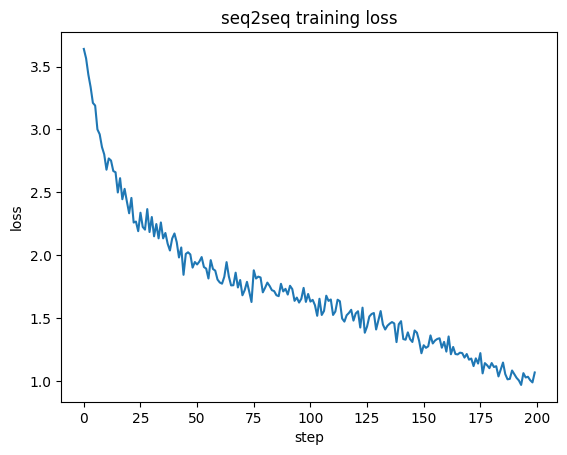

In [ ]:
toy_vocab_size = 32

# Inicializamos el modelo Transformer encoder-decoder
model = MiniTransformer(
    vocab_size=toy_vocab_size,
    max_len=32,
    d_model=64,
    n_heads=4,
    n_layers=2,
    ffn_hidden=128,
    dropout=0.1
).to(device)

# Optimizador Adam (típico en Transformers)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

# Para guardar la evolución de la loss
loss_hist = []

# Entrenamiento
for step in range(200):
    model.train()

    # Batch sintético (teacher forcing)
    src, tgt_in, tgt_out = make_toy_batch(batch_size=64)
    src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)

    # Reset de gradientes
    opt.zero_grad()

    # Forward + loss
    _, loss = model(src, tgt_in, tgt_targets=tgt_out)

    # Backpropagation
    loss.backward()

    # Paso del optimizador
    opt.step()

    # Guardamos loss
    loss_hist.append(loss.item())

    # Logging cada 50 pasos
    if (step + 1) % 50 == 0:
        print(f'step {step+1:03d} | loss {loss.item():.4f}')

# Gráfica de la loss
plt.figure()
plt.plot(loss_hist)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('seq2seq training loss')
plt.show()


## 13) Inferencia greedy (generación en decoder)
Generamos token a token con el decoder, usando máscara causal.
Usamos greedy (argmax) para simplificar.

In [ ]:
@torch.no_grad()
def greedy_decode(model, src_idx, max_new_tokens=20):
    """
    Decodificación autoregresiva greedy para un Transformer encoder-decoder.

    model: modelo entrenado
    src_idx: (B, S) ids de entrada
    max_new_tokens: límite de generación
    devuelve:
      ys: (B, T_gen) secuencia generada (incluye BOS y EOS)
    """
    model.eval()
    src_idx = src_idx.to(device)

    # -------------------------
    # Encoder (una sola vez)
    # -------------------------
    src = model.drop(model.pos_enc(model.tok_emb(src_idx)))
    enc_out = model.encoder(src)   # (B, S, d_model)

    # -------------------------
    # Inicializamos el decoder con BOS
    # -------------------------
    B = src_idx.size(0)
    ys = torch.full((B, 1), BOS, dtype=torch.long, device=device)

    # -------------------------
    # Decodificación autoregresiva
    # -------------------------
    for _ in range(max_new_tokens):
        # Embedding + pos enc del decoder
        tgt = model.drop(model.pos_enc(model.tok_emb(ys)))

        # Decoder con cross-attention al encoder
        dec_out = model.decoder(tgt, enc_out)

        # Logits del último timestep
        logits = model.lm_head(dec_out)[:, -1, :]  # (B, vocab)

        # Elección greedy del siguiente token
        next_tok = logits.argmax(dim=-1, keepdim=True)  # (B,1)

        # Añadimos el token generado
        ys = torch.cat([ys, next_tok], dim=1)

        # Si todas las secuencias generaron EOS, paramos
        if (next_tok == EOS).all():
            break

    return ys

# Probamos
src, tgt_in, tgt_out = make_toy_batch(batch_size=3)
pred = greedy_decode(model, src)
print('src:', src)
print('target_out:', tgt_out)
print('pred:', pred.cpu())

src: tensor([[12,  9,  4,  7,  7,  7,  2,  0],
        [ 3,  8, 10,  2,  0,  0,  0,  0],
        [12, 10, 12, 11,  7,  6,  4,  2]])
target_out: tensor([[22, 19, 14, 17, 17, 17,  2,  0],
        [13, 18, 20,  2,  0,  0,  0,  0],
        [22, 20, 22, 21, 17, 16, 14,  2]])
pred: tensor([[ 1, 22, 17, 22, 17, 17, 17, 17,  2,  2],
        [ 1, 13, 18, 20,  2,  2,  2,  2,  2,  2],
        [ 1, 20, 22, 22, 22, 16, 22, 16, 22,  2]])


### **Ejercicio: hacer una tarea sencilla de traducción de inglés a español**

In [ ]:
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import List, Dict, Tuple
from torch.utils.data import Dataset, DataLoader


# -------------------------
# 1) Vocab + encode/decode
# -------------------------
PAD, BOS, EOS, UNK = 0, 1, 2, 3

@dataclass
class Vocab:
    stoi: Dict[str, int]
    itos: List[str]
    pad: str = "<pad>"
    bos: str = "<bos>"
    eos: str = "<eos>"
    unk: str = "<unk>"

    @property
    def pad_id(self): return self.stoi[self.pad]
    @property
    def bos_id(self): return self.stoi[self.bos]
    @property
    def eos_id(self): return self.stoi[self.eos]
    @property
    def unk_id(self): return self.stoi[self.unk]

def build_vocab_from_parallel(pairs: List[Tuple[str, str]], min_freq: int = 1) -> Vocab:
    # Vocab compartido (porque MiniTransformer tiene un solo embedding tok_emb)
    from collections import Counter
    c = Counter()
    for en, es in pairs:
        c.update(en.lower().split())
        c.update(es.lower().split())
    specials = ["<pad>", "<bos>", "<eos>", "<unk>"]  # ids 0..3
    itos = specials + [w for w, f in c.items() if f >= min_freq and w not in specials]
    stoi = {w: i for i, w in enumerate(itos)}
    return Vocab(stoi=stoi, itos=itos)

def encode_text(v: Vocab, text: str) -> List[int]:
    toks = text.lower().split()
    return [v.stoi.get(w, v.unk_id) for w in toks]

def decode_ids(v: Vocab, ids: List[int]) -> str:
    return " ".join(v.itos[i] if 0 <= i < len(v.itos) else "<oov>" for i in ids)

def pad_2d(seqs: List[List[int]], pad_id: int) -> torch.Tensor:
    T = max(len(s) for s in seqs)
    out = torch.full((len(seqs), T), pad_id, dtype=torch.long)
    for i, s in enumerate(seqs):
        out[i, :len(s)] = torch.tensor(s, dtype=torch.long)
    return out


In [ ]:
# -------------------------
# 2) Datos EN->ES (muy pequeños, para demo)
#    (Puedes añadir más pares para mejorar)
# -------------------------
pairs = [
    ("i like pizza",            "me gusta la pizza"),
    ("i like coffee",           "me gusta el cafe"),
    ("good morning",            "buenos dias"),
    ("good night",              "buenas noches"),
    ("how are you",             "como estas"),
    ("thank you",               "gracias"),
    ("you are welcome",         "de nada"),
    ("i love nlp",              "me encanta el nlp"),
    ("the dog is tired",        "el perro esta cansado"),
    ("the cat is on the sofa",  "el gato esta en el sofa"),
    ("today is sunny",          "hoy hace sol"),
    ("i am learning pytorch",   "estoy aprendiendo pytorch"),
    ("where is the bank",       "donde esta el banco"),
    ("the park is green",       "el parque es verde"),
    ("i go to the beach",       "voy a la playa"),
    ("see you tomorrow",        "hasta manana"),
]

vocab = build_vocab_from_parallel(pairs)
print("Vocab size:", len(vocab.itos))

Vocab size: 74


In [ ]:
# -------------------------
# 3) Dataset seq2seq con teacher forcing
#    src_idx  = [en_tokens] + [EOS]
#    tgt_in   = [BOS] + [es_tokens]
#    tgt_out  = [es_tokens] + [EOS]
# -------------------------
class EnEsDataset(Dataset):
    def __init__(self, pairs: List[Tuple[str, str]], vocab: Vocab):
        self.pairs = pairs
        self.vocab = vocab

    def __len__(self): return len(self.pairs)

    def __getitem__(self, i):
        en, es = self.pairs[i]
        src = encode_text(self.vocab, en) + [self.vocab.eos_id]
        tgt_tokens = encode_text(self.vocab, es)
        tgt_in  = [self.vocab.bos_id] + tgt_tokens
        tgt_out = tgt_tokens + [self.vocab.eos_id]
        return src, tgt_in, tgt_out

def collate_seq2seq(batch, pad_id: int):
    srcs, tgt_ins, tgt_outs = zip(*batch)
    src = pad_2d(list(srcs), pad_id)
    tgt_in = pad_2d(list(tgt_ins), pad_id)
    tgt_out = pad_2d(list(tgt_outs), pad_id)
    return src, tgt_in, tgt_out

dl = DataLoader(
    EnEsDataset(pairs, vocab),
    batch_size=8,
    shuffle=True,
    collate_fn=lambda b: collate_seq2seq(b, vocab.pad_id)
)